## Set Up ##

In [1]:
#checking where I am
!pwd 

/global/u2/c/chanun/cosmic_voids/doc


In [2]:
#import neccessary libaries
import os
import fitsio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
from scipy.stats import mode, skew, kurtosis
%matplotlib inline

In [3]:
#move
%cd

/global/u2/c/chanun


In [4]:
#load unit sims 
ELG = Table.read('full_footprint_cutsky/UNIT_lightcone_multibox_ELG_footprint_nz_cutsky_snap102.fits')
QSO = Table.read('full_footprint_cutsky/UNIT_lightcone_multibox_QSO_footprint_nz_cutsky_snap102.fits')
LRG = Table.read('full_footprint_cutsky/UNIT_lightcone_multibox_LRG_footprint_nz_cutsky_snap102.fits')

In [5]:
#move to scratch
%cd scratch

/global/cscratch1/sd/chanun


In [6]:
#loading in data files

#Zobov voids
south = np.loadtxt('testrevenv/revolver-test/zobov-recon-voids_cat.txt',skiprows=2,unpack=True)
north = np.loadtxt('testrevenv/revolver-test-north/zobov-recon-voids_cat.txt',skiprows=2,unpack=True)

#Buffer particles for north and south
#x,y,z,RA,DEC
rbpn = np.load('testrevenv/revolver-test-north/DR12_CMASS_North_mocks.npy').T
rbps = np.load('testrevenv/revolver-test/DR12_CMASS_South_mocks.npy').T

#Voxel voids
voxelsouth = np.loadtxt('testrevenv/revolver-test/voxel-recon-voids_cat.txt',skiprows=2, unpack=True)

#South CMASS galaxies
southgal = Table.read('testrevenv/galaxy_DR12v5_CMASS_South.fits')
northgal = Table.read('testrevenv/galaxy_DR12v5_CMASS_North.fits')

#BOSS DR12 Voids
bossvoids = np.loadtxt('testrevenv/BOSS_DR12_Voids.txt', dtype='str',unpack=True)

#Unitsims
lrg = np.loadtxt('testrevenv/revolver-unitsims-LRG/zobov-recon-voids-LRG_cat.txt',skiprows=2,unpack=True)
qso = np.loadtxt('testrevenv/revolver-unitsims-QSO/zobov-recon-voids-QSO_cat.txt',skiprows=2,unpack=True)

## Functions ##

In [7]:
def fill_between(x, y1, y2=0, ax=None, **kwargs):
    """Plot filled region between `y1` and `y2`. Works exactly the same as matplotlib's fill_between, 
    except that it also plots a proxy artist (specifically, a rectangle of 0 size) 
    so that it can be added to a legend. Adapted from VIDE. """
    ax = ax if ax is not None else plt.gca()
    ax.fill_between(x, y1, y2, interpolate=True, **kwargs)
    p = plt.Rectangle((0, 0), 0, 0, **kwargs)
    ax.add_patch(p)

In [8]:
def findangdiam(redshift,effectiverad,cosmology):
    '''Given redshift, physical size, and cosmology we can find the angular diameter distance and angular size'''
    angdiameter = cosmology.angular_diameter_distance(redshift)
    theta = (effectiverad/angdiameter.value)* (180/np.pi) #this is in degrees 
    delta = theta/ np.cos(theta)
    return angdiameter, theta, delta

In [9]:
def numberfunction(radii,volume,labels,bins=100,a1=0.5,a2=0.9,cumulative=True,plot=True):
    ''' Plot a cumulative (or not) number function given a list of radii and volumes (and labels for the legend).
    Returns bincenters, mean, lower and upper bounds as a list within a list. Adapted from VIDE'''
    data = []
    
    if plot:
            plt.clf()
            plt.figure(figsize=(10,8))
            plt.xlabel("$R_{eff}$ [$h^{-1}Mpc$]", fontsize=14)

            if cumulative:
                plt.ylabel(r"log ($n$ (> R) [$h^3$ Gpc$^{-3}$])", fontsize=14)
            else:
                plt.ylabel(r"log ($dn/dR$ [$h^3$ Gpc$^{-3}$])", fontsize=14)
                
    for i in range(0,len(radii)):
        counts, binedges = np.histogram(radii[i], bins=bins)
        bincenters = 0.5*(binedges[1:]+binedges[:-1])
        
        if cumulative:
            cond = False
            for j in range(len(counts)):
                if not cond and counts[j] ==0:
                    continue
                else:
                    cond = True
                    counts[j] = np.sum(counts[j:])
    
        nvoids = len(radii[i])
        var = counts * (1. - counts/nvoids)
        sig = np.sqrt(var)
        vol = volume*10**-9 
        m = np.log10(counts/vol)
        lowerbound = np.log10((counts - sig)/vol)
        upperbound = np.log10((counts + sig)/vol)
    
        #trimming
        trim = (lowerbound > .01)
        m = m[trim]
        bincen = bincenters[trim]
        lower = lowerbound[trim]
        upper = upperbound[trim]
        data.append([bincen,m,lower,upper])
    
                
        if plot:
            fill_between(bincen, lower, upper,alpha=a2,edgecolor='k')
            plt.plot(bincen, m, '-',label=labels[i],alpha=a1)
            plt.legend()
    
    return data 

In [10]:
def plotcdf(datas,labels,bins=100,plot=True,figsize=(8,6)):
    '''Plot the cumulative distribution function and probability distribution function (optional given a list of catalogues.
    Returns cdf, pdf, bincenters (x-axis) respectively. ''' 
    information = []
    
    if plot:
        plt.figure(figsize=figsize)
        
    for i in range(0,len(datas)):
        counts, bincenters = np.histogram(datas[i],bins=bins)
        #bincenters = 0.5*(bincounts[1:]+bincounts[:-1])
        pdf = counts / sum(counts) #probability cdf = np.cumsum(pdf) #adding the probs
        cdf = np.cumsum(pdf)
        information.append([cdf,pdf,bincenters])
        if plot:
            plt.plot(bincenters[1:],cdf, label=f"CDF:{labels[i]}")
            plt.xlabel('$R_{eff}$ [$Mpc/h$]',fontsize=14)
            plt.ylabel('Probability',fontsize=14)
            plt.ylim(0,1.02)
            #if plotboth:
                #plt.plot(bincenters[1:],pdf, label=f"PDF:{labels[i]}")
            plt.legend()
            
    return information

In [11]:
def getstats(data,b=100, plot=True):
    '''Returns mode, mean, std, skew, kurtosis, 25th, 50th, 75th percentile. 
    Skew: measure of asymmetry- 0 for norm dist (no skewness), positive right tail, negative left tail.
    Kurtosis: measure if a dist is heavy-tailed or light-tailed- 0 for normal fisher, positive heavy-tailed (more outliers than norm dist), negative light-tailed'''
    m, mc, a, std, s, k, q, h, f = mode(data)[0][0], mode(data)[1][0], data.mean(), np.std(data), skew(data), kurtosis(data), np.percentile(data,25), np.percentile(data,50), np.percentile(data,75)
    if plot:
        plt.figure(figsize=(10,8))
        plt.hist(data,bins=b,color='deepskyblue')
        plt.axvline(q,linestyle='--',color='k')
        plt.axvline(h,linestyle='--',color='k',label='quartiles')
        plt.axvline(f,linestyle='--',color='k')
        plt.axvline(a,linestyle='--',color='firebrick',label='mean')
        plt.axvline(m,linestyle='--',color='darkorange',label='mode')
        plt.ylabel('Number of Voids',fontsize=14)
        plt.xlabel('$R_{eff}$ [$Mpc/h$]', fontsize=14)
        plt.legend()
        print('mode: {}'.format(m))
        print('mode count: {}'.format(mc))
        print('mean: {}'.format(a))
        print('std: {}'.format(std))
        print('skew: {}'.format(s))
        print('kurtosis: {}'.format(k))
        
    return m, mc, a, std, s, k, q, h, b

In [12]:
def radecz_to_xyz(radecz, cosmo=None):
    """
    radecz - array of RA, Dec (both in decimal degrees), Z

    returns tuple of XYZ in Mpc Cartesian coordinates

    """
    if cosmo is None:
        from astropy.cosmology import FlatLambdaCDM
        cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

    ra, dec, zz = radecz
    dist = cosmo.comoving_distance(zz).value # [Mpc]

    conv = np.pi/180. # convert degrees --> radians
    cos_dec = np.cos(dec*conv)
    x = dist*cos_dec*np.cos(ra*conv)
    y = dist*cos_dec*np.sin(ra*conv)
    z = dist*np.sin(dec*conv)
    
    return np.array([x, y, z]) # [3, N] array

## Comparing Revolver Voids and BOSS Voids ##

In [13]:
#to get just cmass voids from boss
maskcmassnorth = (bossvoids[0]=='CMASS') & (bossvoids[1]=='North')
maskcmasssouth = (bossvoids[0]=='CMASS') & (bossvoids[1]=='South')

In [14]:
#col 6: Ngal- number of galaxies in the void
#col 7: V- Voronoi volume of the void
#col 9: n_min- number density of the of the minimum density Vornoi cell in the void
#col 10: delat_min- density contrast of the minimum density cell comparing to the mean desnity of that z
#col 11: r- the ratio between the minimum density particle on a ridge to the minimum density particle in the void
#col 12: P- prob. that the void arises from Poisson fluctuations

bnid = bossvoids[2][maskcmassnorth].astype(float) #id
bnra = bossvoids[3][maskcmassnorth].astype(float) #ra
bndec = bossvoids[4][maskcmassnorth].astype(float) #dec 
bnz = bossvoids[5][maskcmassnorth].astype(float) #redshift, z
bnreff = bossvoids[8][maskcmassnorth].astype(float) #reff
bnd = bossvoids[13][maskcmassnorth].astype(float) #distance form boundary

bsid = bossvoids[2][maskcmasssouth].astype(float)
bsra = bossvoids[3][maskcmasssouth].astype(float)
bsdec = bossvoids[4][maskcmasssouth].astype(float)
bsz = bossvoids[5][maskcmasssouth].astype(float)
bsreff = bossvoids[8][maskcmasssouth].astype(float) 
bsd = bossvoids[13][maskcmasssouth].astype(float)

In [15]:
bra = np.concatenate((bnra, bsra))
bdec = np.concatenate((bndec, bsdec))
bz = np.concatenate((bnz, bsz))
breff = np.concatenate((bnreff, bsreff))
#########################################
rra = np.concatenate((north[1],south[1]))
rdec = np.concatenate((north[2],south[2]))
rz = np.concatenate((north[3],south[3]))
rreff = np.concatenate((north[4],south[4]))

In [16]:
#parameters
#parameters
a1 = 0.55
vol = 10.8 #10.8 * 10**9 #Gpc3
radii = [rreff,breff]
labels = ['Revolver CMASS Voids','BOSS CMASS Voids']

<Figure size 432x288 with 0 Axes>

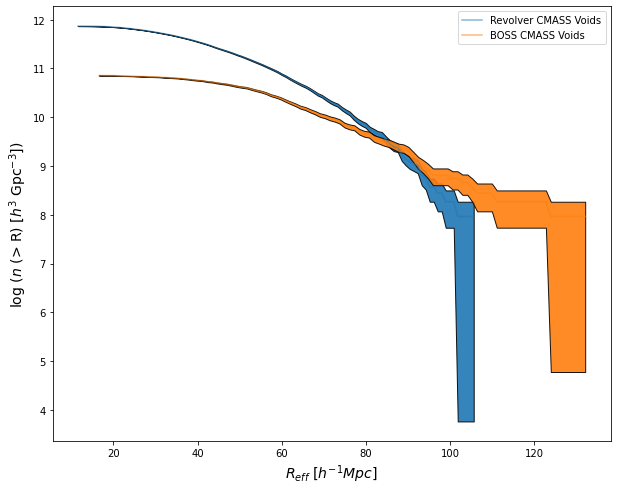

In [17]:
#cumulative number function
nf = numberfunction(radii,vol,labels,a1=a1);

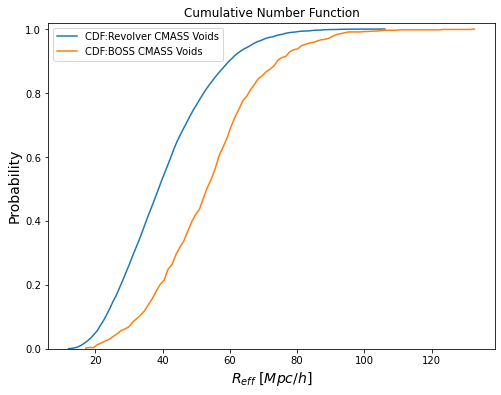

In [18]:
info = plotcdf(datas=radii,labels=labels)
plt.title('Cumulative Number Function');

mode: 41.139
mode count: 2
mean: 53.39460465116279
std: 16.523325454528138
skew: 0.497130221650456
kurtosis: 0.8884692612867999


Text(0.5, 1.0, 'BOSS Voids')

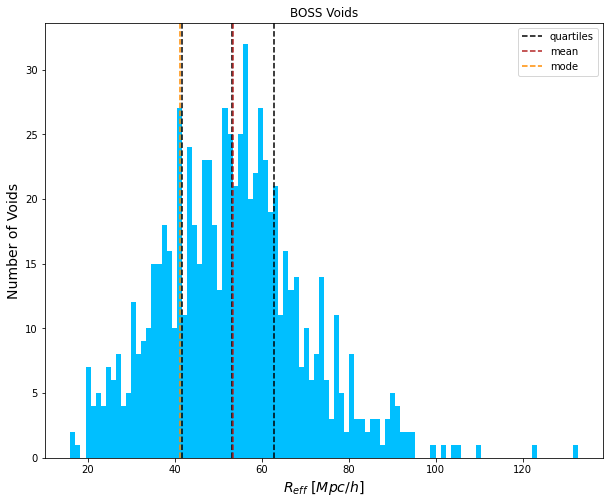

In [19]:
g = getstats(breff)
plt.title('BOSS Voids')

mode: 20.8254
mode count: 2
mean: 40.329379681624474
std: 14.260008364035803
skew: 0.6006763653234688
kurtosis: 0.1681389701203697


Text(0.5, 1.0, 'Revolver Voids')

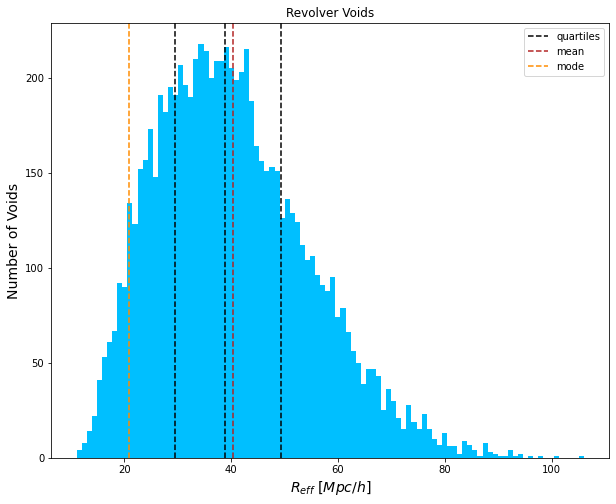

In [20]:
h = getstats(rreff)
plt.title('Revolver Voids')

mode: 0.459
mode count: 11
mean: 0.5467131782945737
std: 0.06587864033728338
skew: 0.2959299414804858
kurtosis: -1.176322237214199


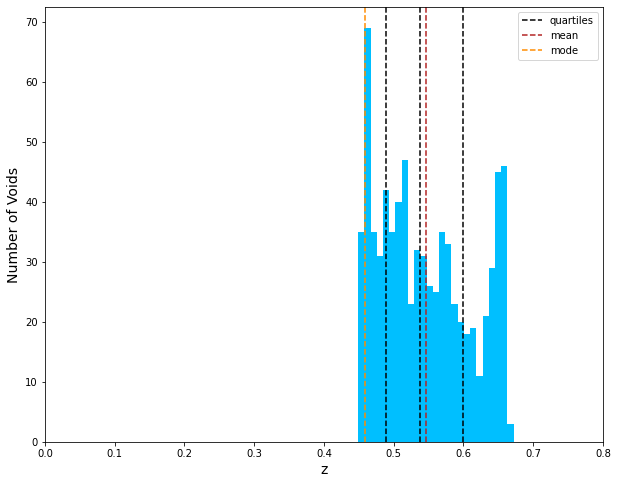

In [21]:
m, mc, a, std, s, k, q, h, f = getstats(bz,b=25)
plt.xlim(0,0.8)
plt.xlabel('z');

Text(0, 0.5, 'Distance to boundary')

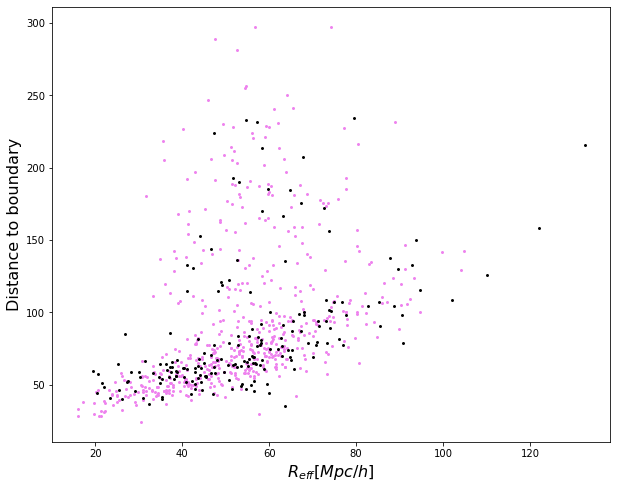

In [22]:
plt.figure(figsize=(10,8))
plt.scatter(bnreff,bnd,s=15,color='violet',marker='.')
plt.scatter(bsreff,bsd,s=15,color='k',marker='.')
plt.xlabel('$R_{eff} [Mpc/h]$',fontsize = 16)
plt.ylabel('Distance to boundary', fontsize = 16)
#plt.ylim(0,180)
#Figure from Mao et al. 2016

## Void Profiles ##

In [29]:
#redshift cut for galaxies
zn = (northgal['Z'] > 0.43) & (northgal['Z'] < 0.7)
zs = (southgal['Z'] > 0.43) & (southgal['Z'] < 0.7)

In [30]:
# x, y, z of galaxies
xn, yn, zn = radecz_to_xyz([northgal['RA'][zn],northgal['DEC'][zn],northgal['Z'][zn]])
xs, ys, zs = radecz_to_xyz([southgal['RA'][zs],southgal['DEC'][zs],southgal['Z'][zs]])

In [31]:
#cartesian coords of boss voids
bnx, bny, bnz2 = radecz_to_xyz([bnra,bndec,bnz])
bsx, bsy, bsz2 = radecz_to_xyz([bsra,bsdec,bsz])

#cartesian coords of revolver voids
rnx, rny, rnz = radecz_to_xyz([north[1],north[2],north[3]])
rsx, rsy, rsz = radecz_to_xyz([south[1],south[2],south[3]])

## UNIT Sims ##

<Figure size 432x288 with 0 Axes>

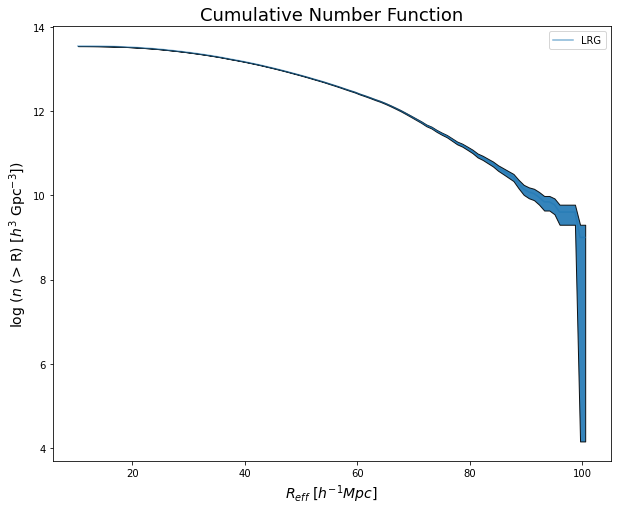

In [24]:
v = 1
nf = numberfunction([lrg[4]],volume=v,labels=['LRG'],a1=0.55)
plt.title('Cumulative Number Function', fontsize=18);

<Figure size 432x288 with 0 Axes>

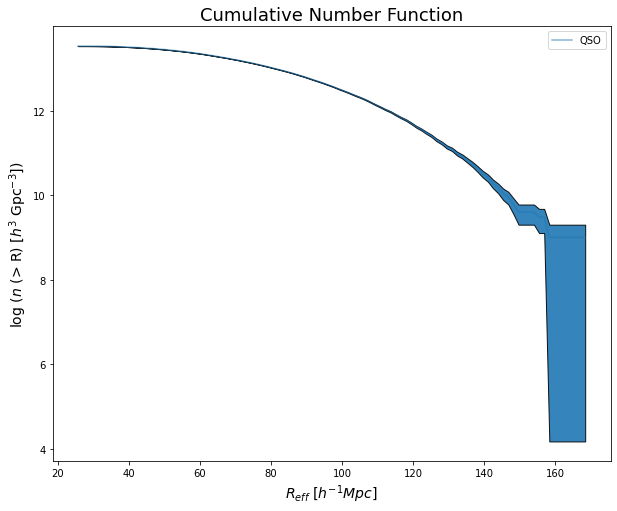

In [25]:
nf = numberfunction([qso[4]],volume=v,labels=['QSO'],a1=0.55)
plt.title('Cumulative Number Function', fontsize=18);

mode: 32.7487
mode count: 4
mean: 38.2876352453865
std: 13.57179129197479
skew: 0.5498144735692353
kurtosis: -0.003063267367716005


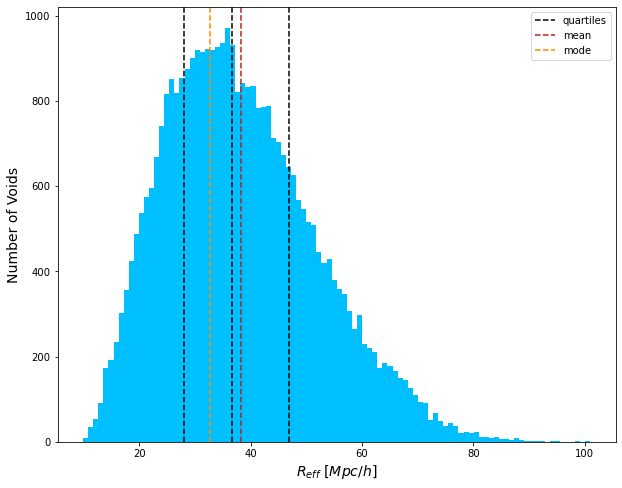

In [27]:
a = getstats(lrg[4])

mode: 55.5333
mode count: 3
mean: 69.76996896674268
std: 20.658818437823413
skew: 0.4325707808086447
kurtosis: -0.18280120607096517


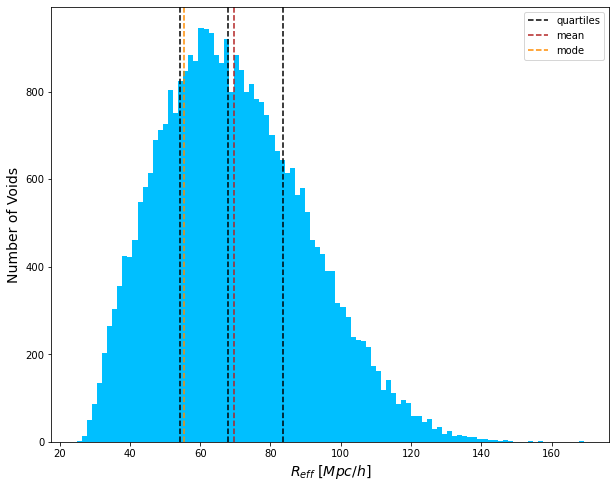

In [28]:
b = getstats(qso[4])